In [45]:
#Laod current hamiltonian file
using LinearAlgebra, Plots, Graphs, ProgressBars, Base.Threads, Statistics
include("../src/graphs.jl")
include("../src/observables.jl")

binned_average (generic function with 2 methods)

In [46]:
# parameters
SIZE_LIST = [20, 40, 80, 160] # number of sites
NUM_SAMPLES = 1
DISORDER_LIST = 10 .^ LinRange(-2, 3, 30) 
ENERGY_BINS = LinRange(0, 0.95, 20)

function graph_of_size(L)
    return chain_graph(L, periodic=false)
end

function onsite_and_hopping_of_disorder(graph, disorder)
    E = disorder * cos(sqrt(2) * π) .* LinRange(1, nv(graph), nv(graph))
    V = 1.0
    return E, V
end

onsite_and_hopping_of_disorder (generic function with 1 method)

In [47]:
function compute_observables_per_size_and_disorder(sizes, disorders, num_samples)
    # get localization of the ground state as a function of disorder
    iprs = zeros(length(sizes), length(disorders))
    iprs_std = zeros(length(sizes), length(disorders))
    agrs = zeros(length(sizes), length(disorders))
    agrs_std = zeros(length(sizes), length(disorders))
    for (size_idx, L) in enumerate(sizes)
        graph = graph_of_size(L)
        for (disorder_idx, disorder) in enumerate(disorders)
            ipr_sample_arr = zeros(num_samples)
            agr_sample_arr = zeros(num_samples)
            for n in 1:num_samples
                # chain_hamiltonian = hamiltonian_from_graph(graph, disorder * rand(nv(graph)), 1.0)
                E, V = onsite_and_hopping_of_disorder(graph, disorder)
                chain_hamiltonian = hamiltonian_from_graph(graph, E, V) 
                eigval_vec, eigvec_mat  = eigen(chain_hamiltonian)
                ipr_sample_arr[n] = inverse_participation_ratio(eigvec_mat[:, 1])
                agr_sample_arr[n] = adjacent_gap_ratio(eigval_vec)
            end
            iprs[size_idx, disorder_idx] = mean(ipr_sample_arr)
            iprs_std[size_idx, disorder_idx] = stdm(ipr_sample_arr, iprs[size_idx, disorder_idx])
            agrs[size_idx, disorder_idx] = mean(agr_sample_arr)
            agrs_std[size_idx, disorder_idx] = stdm(agr_sample_arr, agrs[size_idx, disorder_idx])
        end
    end
    return iprs, iprs_std, agrs, agrs_std
end

iprs_arr, iprs_std_arr, agrs_arr, agrs_std_arr = compute_observables_per_size_and_disorder(SIZE_LIST, DISORDER_LIST, NUM_SAMPLES)


([0.07358744364100908 0.07596142816708609 … 0.999937594386901 0.999971789129395; 0.05794041845444769 0.06613319948139654 … 0.999937594386901 0.999971789129395; 0.05791650514880662 0.0661317289100107 … 0.999937594386901 0.999971789129395; 0.057916505148803255 0.06613172891000935 … 0.999937594386901 0.999971789129395], [NaN NaN … NaN NaN; NaN NaN … NaN NaN; NaN NaN … NaN NaN; NaN NaN … NaN NaN], [0.856892692406515 0.8591647637504789 … 0.9999965329403481 0.999998432712823; 0.9196275828283481 0.9218687358912333 … 0.9999983577085727 0.9999992576007959; 0.9536413818495438 0.9560715908418553 … 0.999999199909282 0.9999996383183231; 0.9753440060868311 0.9766333026539319 … 0.9999996050184728 0.9999998214482478], [NaN NaN … NaN NaN; NaN NaN … NaN NaN; NaN NaN … NaN NaN; NaN NaN … NaN NaN])

In [55]:
function compute_energy_resolved_ipr_per_disorder(graph, energy_bins, disorders, num_samples)
    iprs = zeros(length(energy_bins)-1, length(disorders))
    for (disorder_idx, disorder) in enumerate(disorders)
        ipr_sample_arr = zeros(length(energy_bins)-1, num_samples)
        for n in 1:num_samples
            E, V = onsite_and_hopping_of_disorder(graph, disorder)
            chain_hamiltonian = hamiltonian_from_graph(graph, E, V) 
            eigval_vec, eigvec_mat  = eigen(chain_hamiltonian)
            ipr = inverse_participation_ratio(eigvec_mat)
            ipr_sample_arr[:, n] = binned_average(eigval_vec / disorder, ipr, energy_bins)
        end
        iprs[:, disorder_idx] = mean(ipr_sample_arr, dims=2)
    end
    return iprs
end

iprs_per_energy = compute_energy_resolved_ipr_per_disorder(graph_of_size(SIZE_LIST[end]), ENERGY_BINS, DISORDER_LIST, NUM_SAMPLES)

19×30 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

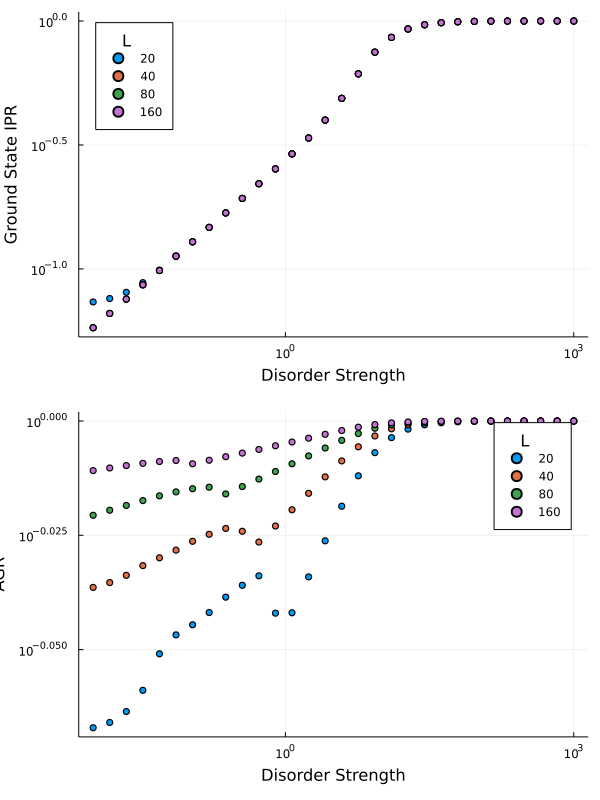

In [49]:
# Look at iprs as function of disorder
ipr_plot = scatter(
        # xaxis = :log,
        scale = :log,
        xlabel = "Disorder Strength",
        ylabel = "Ground State IPR",
        legend = :topleft,
        legendtitle = "L"
)

agr_plot = scatter(
    # xaxis = :log,
    scale = :log,
    xlabel = "Disorder Strength",
    ylabel = "AGR",
    legend = :topright,
    legendtitle = "L"
)

for (L, ipr, ipr_std) in zip(SIZE_LIST, eachrow(iprs_arr), eachrow(iprs_std_arr))
    scatter!(ipr_plot, DISORDER_LIST, ipr, yerror=ipr_std, label = L)
end

for (L, agr, agr_std) in zip(SIZE_LIST, eachrow(agrs_arr), eachrow(agrs_std_arr))
    scatter!(agr_plot, DISORDER_LIST, agr, yerror=agr_std, label = L)
end


plot(ipr_plot, agr_plot, layout=(2, 1), size=(600, 800))

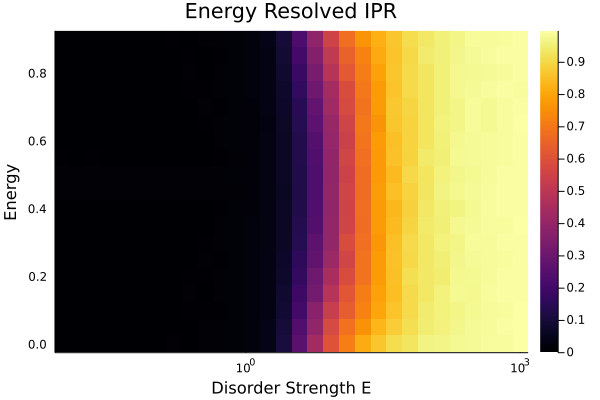

In [50]:
energy_bin_centers = ENERGY_BINS[1:end-1]
heatmap(DISORDER_LIST, energy_bin_centers, iprs_per_energy;
    xaxis = :log,
    xlabel = "Disorder Strength E",
    ylabel = "Energy",
    title = "Energy Resolved IPR"
)